## Learning Sparse Reward Models

We consider the case of learning the reward function of the pendulum. In particular, we aim to learn the reward function $R:\mathcal{S}\times \mathcal{A}\rightarrow \mathbb{R}$, predicting the reward $\hat{r}_t$ from the current state $\mathbf{s}_t$ and action $\mathbf{a}_t$: $$\hat{r}_t=R(\mathbf{s}_t, \mathbf{a}_t).$$ We will approximate $R(\mathbf{s}_t, \mathbf{a}_t)$ using:
* a fully-connected neural network (fcnn_model),
* a fully-connected neural network sparsified by the L$_0$ regularization (sparsefcnn_model), and
* a SINDy-like architecture again sparsified by the L$_0$ regularization (l0sindy_model).

In [25]:
import gymnasium as gym
from utils.replay_buffer import ReplayBuffer
import torch
import numpy as np

# Set seeds
seed = 23524
torch.manual_seed(seed)
np.random.seed(seed)

We first create a training set composed of 1000 episodes of 200 steps each. The actions are sampled from a random policy.

In [26]:
render = False
if render:
    env = gym.make('Pendulum-v1', g=9.81, render_mode="human")
else:
    env = gym.make('Pendulum-v1', g=9.81)
max_episodes = 1000
max_steps = 200

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
buf_dim = int(max_episodes*max_steps)

# create training set
training_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim, size=buf_dim)

for episode in range(max_episodes):
    observation, _ = env.reset()
    for steps in range(max_steps+1):
        action = env.action_space.sample() 
        next_observation, reward, terminated, truncated, _ = env.step(action)

        done = terminated or truncated
        training_buffer.store(observation, action, reward, next_observation, done)

        env.render()

        observation = next_observation

        if done:
            done = False
            break

print("Finished creating the training set")

/home/nicolo/Documents/Sparsifying-Parametric-Models-with-L0/venv/lib/python3.10/site-packages/gymnasium/envs/classic_control/pendulum.py:173: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("Pendulum-v1", render_mode="rgb_array")
  gym.logger.warn(


Finished creating the training set


Secondly, we create the test set that we will use to evaluate the models.

In [27]:
# create test set
max_episodes_test = 100
buf_dim = int(max_episodes*max_steps)

testing_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim, size=buf_dim)

for episode in range(max_episodes_test):
    observation, _ = env.reset()
    for steps in range(max_steps + 1):
        action = env.action_space.sample()  
        next_observation, reward, terminated, truncated, _ = env.step(action)

        done = terminated or truncated
        testing_buffer.store(observation, action, reward, next_observation, done)

        env.render()

        observation = next_observation

        if done:
            done = False
            break

print("Finished creating the test set")

Finished creating the test set


After creating train and test set, we are now ready to train the three models. We utilize the same learning rate, batch size, and number of traning epochs.


In [28]:
# learning the reward function of the pendulum
from utils.models import FCNN, SparseFCNN, L0SINDy_reward
from utils.trainer import train_eval_reward_model
import torch

# number of hidden units used by the fcnn_model and the sparsefcnn_model
h_dim = 128

# shared hyperparameter of the experiment
lr = 3e-4
batch_size = 256
num_epochs = 500

Train and evaluate the fcnn_model.

In [29]:
fcnn_model = FCNN(input_dim=obs_dim+act_dim, output_dim=1, h_dim=h_dim)

if torch.cuda.is_available():
    fcnn_model = fcnn_model.cuda()

optimizer_fcnn = torch.optim.Adam([
    {'params': fcnn_model.parameters()},
], lr=lr, weight_decay=0.0)

metrics_fcnn = train_eval_reward_model(fcnn_model, optimizer_fcnn, training_buffer, testing_buffer, batch_size, num_epochs)
print("Best testing error FCNN is {} and it was found at epoch {}".format(metrics_fcnn[2], metrics_fcnn[3]))

====> Epoch: 0 Average eval loss: 0.2242373675
====> Epoch: 1 Average eval loss: 0.1555906683
====> Epoch: 2 Average eval loss: 0.0955389962
====> Epoch: 3 Average eval loss: 0.0506766774
====> Epoch: 4 Average eval loss: 0.0323671512
====> Epoch: 5 Average eval loss: 0.0183821898
====> Epoch: 6 Average eval loss: 0.0121691236
====> Epoch: 7 Average eval loss: 0.0085523184
====> Epoch: 8 Average eval loss: 0.0061701760
====> Epoch: 9 Average eval loss: 0.0050227093
====> Epoch: 10 Average eval loss: 0.0075902031
====> Epoch: 11 Average eval loss: 0.0044573457
====> Epoch: 12 Average eval loss: 0.0041646799
====> Epoch: 13 Average eval loss: 0.0036856132
====> Epoch: 14 Average eval loss: 0.0027860457
====> Epoch: 15 Average eval loss: 0.0037177089
====> Epoch: 16 Average eval loss: 0.0020456859
====> Epoch: 17 Average eval loss: 0.0060423431
====> Epoch: 18 Average eval loss: 0.0029456445
====> Epoch: 19 Average eval loss: 0.0060066800
====> Epoch: 20 Average eval loss: 0.0038782619
==

Train and evaluate the sparsefcnn_model.

In [30]:
reg_coefficient = 0.0005
sparsefcnn_model = SparseFCNN(input_dim=obs_dim+act_dim, output_dim=1, h_dim=h_dim, lambda_coeff=reg_coefficient)

if torch.cuda.is_available():
    sparsefcnn_model = sparsefcnn_model.cuda()

optimizer_sparsefcnn = torch.optim.Adam([
    {'params': sparsefcnn_model.parameters()},
], lr=lr, weight_decay=0.0)

metrics_sparsefcnn = train_eval_reward_model(sparsefcnn_model, optimizer_sparsefcnn, training_buffer, testing_buffer,
                                               batch_size, num_epochs, l0=True)
print("Best testing error sparse FCNN is {} and it was found at epoch {}".format(metrics_sparsefcnn[2], metrics_sparsefcnn[3]))


L0Dense(4 -> 128, droprate_init=0.5, lamba=0.0005, temperature=0.6666666666666666, weight_decay=0.0, local_rep=False)
L0Dense(128 -> 128, droprate_init=0.5, lamba=0.0005, temperature=0.6666666666666666, weight_decay=0.0, local_rep=False)
L0Dense(128 -> 1, droprate_init=0.5, lamba=0.0005, temperature=0.6666666666666666, weight_decay=0.0, local_rep=False)


/home/nicolo/Documents/Sparsifying-Parametric-Models-with-L0/utils/l0_layer.py:51: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.weights, mode='fan_out')


====> Epoch: 0 Average eval loss: 2.6028380394
====> Epoch: 1 Average eval loss: 2.6091704369
====> Epoch: 2 Average eval loss: 2.6171121597
====> Epoch: 3 Average eval loss: 2.3126416206
====> Epoch: 4 Average eval loss: 2.2280967236
====> Epoch: 5 Average eval loss: 2.0264084339
====> Epoch: 6 Average eval loss: 1.8241566420
====> Epoch: 7 Average eval loss: 1.7464517355
====> Epoch: 8 Average eval loss: 1.5395720005
====> Epoch: 9 Average eval loss: 1.5218701363
====> Epoch: 10 Average eval loss: 1.3187063932
====> Epoch: 11 Average eval loss: 1.2107037306
====> Epoch: 12 Average eval loss: 1.7120019197
====> Epoch: 13 Average eval loss: 1.1185638905
====> Epoch: 14 Average eval loss: 1.1201074123
====> Epoch: 15 Average eval loss: 1.1884884834
====> Epoch: 16 Average eval loss: 1.1545605659
====> Epoch: 17 Average eval loss: 0.9281610847
====> Epoch: 18 Average eval loss: 0.9276879430
====> Epoch: 19 Average eval loss: 0.8349093795
====> Epoch: 20 Average eval loss: 0.8748819232
==

Train and evaluate the l0sindy_model.

In [31]:
# degree of the polynomial features
degree = 3

reg_coefficient = 0.0005
l0sindy_model = L0SINDy_reward(input_dim=obs_dim+act_dim, output_dim=1, degree=degree, lambda_coeff=reg_coefficient)

if torch.cuda.is_available():
    l0sindy_model = l0sindy_model.cuda()

optimizer_fcnn = torch.optim.Adam([
    {'params': l0sindy_model.parameters()},
], lr=lr, weight_decay=0.0)

metrics_l0sindy = train_eval_reward_model(l0sindy_model, optimizer_fcnn, training_buffer, testing_buffer, batch_size, num_epochs, l0=True)
print("Best testing error L0 SINDy is {} and it was found at epoch {}".format(metrics_l0sindy[2], metrics_l0sindy[3]))

l0sindy_model.print_equations()

policy polynomial of order  3
with 35 coefficients
['1' 'x0' 'x1' 'x2' 'x3' 'x0^2' 'x0 x1' 'x0 x2' 'x0 x3' 'x1^2' 'x1 x2'
 'x1 x3' 'x2^2' 'x2 x3' 'x3^2' 'x0^3' 'x0^2 x1' 'x0^2 x2' 'x0^2 x3'
 'x0 x1^2' 'x0 x1 x2' 'x0 x1 x3' 'x0 x2^2' 'x0 x2 x3' 'x0 x3^2' 'x1^3'
 'x1^2 x2' 'x1^2 x3' 'x1 x2^2' 'x1 x2 x3' 'x1 x3^2' 'x2^3' 'x2^2 x3'
 'x2 x3^2' 'x3^3']
L0Dense(35 -> 1, droprate_init=0.5, lamba=0.0003, temperature=0.6666666666666666, weight_decay=0.0, local_rep=False, bias=False)


/home/nicolo/Documents/Sparsifying-Parametric-Models-with-L0/utils/l0_layer.py:51: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.weights, mode='fan_out')


====> Epoch: 0 Average eval loss: 56.9089736938
====> Epoch: 1 Average eval loss: 30.5081157684
====> Epoch: 2 Average eval loss: 19.4083766937
====> Epoch: 3 Average eval loss: 14.3223829269
====> Epoch: 4 Average eval loss: 10.9057102203
====> Epoch: 5 Average eval loss: 8.5602312088
====> Epoch: 6 Average eval loss: 6.8299779892
====> Epoch: 7 Average eval loss: 5.5918631554
====> Epoch: 8 Average eval loss: 4.5806827545
====> Epoch: 9 Average eval loss: 3.7504589558
====> Epoch: 10 Average eval loss: 3.0535631180
====> Epoch: 11 Average eval loss: 2.4577336311
====> Epoch: 12 Average eval loss: 1.9992538691
====> Epoch: 13 Average eval loss: 1.5816576481
====> Epoch: 14 Average eval loss: 1.3170291185
====> Epoch: 15 Average eval loss: 1.1563256979
====> Epoch: 16 Average eval loss: 1.0212298632
====> Epoch: 17 Average eval loss: 0.9242466688
====> Epoch: 18 Average eval loss: 0.8519048691
====> Epoch: 19 Average eval loss: 0.7418558002
====> Epoch: 20 Average eval loss: 0.71045941

Eventually, we plot the mean-squared error between the predictions and the ground-truth over the training and test set.

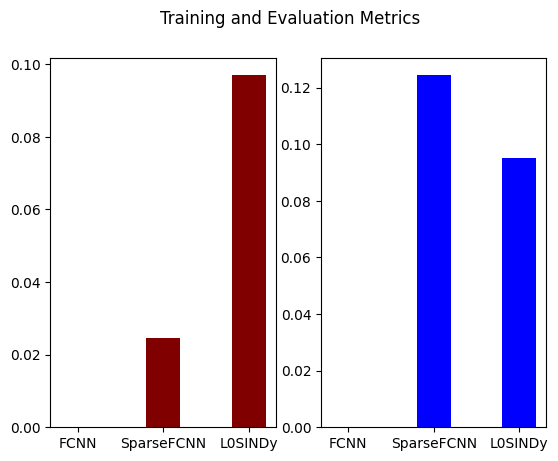

In [35]:
# creating the plots
import matplotlib.pyplot as plt
import os

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Training and Evaluation Metrics')

data_train = {'FCNN': metrics_fcnn[0], 'SparseFCNN': metrics_sparsefcnn[0], 'L0SINDy': metrics_l0sindy[0]}
methods_train = list(data_train.keys())
values_train = list(data_train.values())

# creating the bar plot
ax1.bar(methods_train, values_train, color='maroon', width=0.4)

data_eval = {'FCNN': metrics_fcnn[2], 'SparseFCNN': metrics_sparsefcnn[2], 'L0SINDy': metrics_l0sindy[2]}
methods_eval = list(data_eval.keys())
values_eval = list(data_eval.values())

ax2.bar(methods_eval, values_eval, color='blue', width=0.4)

save_dir = "figures"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
fig.savefig('figures/LearningReward.png', dpi=300)